In [326]:
import os
from pathlib import Path
import sqlite3
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import polyline as ppl
from pyproj import Geod
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime as dt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [327]:
# data directory and files

data_dir = Path.cwd().parents[0] / "data"
wzdx_data_file = data_dir / "az511.db"
# inrix_data_dir = data_dir/ "INRIX data"
# inrix_data_1 = inrix_data_dir / "I10-and-I17-1year" / "I10-and-I17-1year.csv"
# inrix_data_2 = inrix_data_dir / "Loop101-1year" / "Loop101-1year.csv"
# inrix_data_3 = inrix_data_dir / "SR60-1year" / "SR60-1year.csv"

In [328]:
# Defining methods to get data
# The name of the table in wzdx is events. Since this table is small, it can be loaded into the pandas dataframe directly w/o using too much memory.

def data_wzdx(data_file):
    con = sqlite3.connect(data_file)
    cur = con.cursor()

    cur.execute("SELECT * FROM events")
    columns = [desc[0] for desc in cur.description]

    data_df = pd.DataFrame(cur.fetchall(), columns=columns)

    con.close()

    return data_df

def data_inrix(data_file, n=1000):
    data = pd.read_csv(data_file, nrows=n)
    return data

In [329]:
df = data_wzdx(wzdx_data_file)

def line_from_encoded(enc):
    if pd.isna(enc) or enc == '':
        return None
    coords_latlon = ppl.decode(enc)
    coords_lonlat = [(lon, lat) for (lat, lon) in coords_latlon]
    return LineString(coords_lonlat)

In [330]:
# Converting epochs into local time

time_columns = ['Reported', 'LastUpdated', 'StartDate', 'PlannedEndDate']

for col in time_columns:
    df['Local' + col] = df[col]%10000000000
    df['Local' + col] = pd.to_datetime(df['Local' + col], unit='s', utc=True).dt.tz_convert("America/Phoenix").dt.strftime("%Y-%m-%d %H:%M:%S")


In [331]:
# min_lat, max_lat = 33.05, 33.85
# min_lon, max_lon = -112.72,-111.45

# min_lat, max_lat = 33.292405, 33.429615
# min_lon, max_lon = -112.041268, -111.962923


geom = []
geo_mask = False

# for (lat_min, lat_max, lon_min, lon_max) in i10_boxes:
#     geo_mask |= (df['Latitude'].between(lat_min, lat_max) &
#              df['Longitude'].between(lon_min, lon_max))

# geo_mask = df["Latitude"].between(min_lat, max_lat) & df["Longitude"].between(min_lon, max_lon)
# df_in = df.loc[geo_mask]


lat_min, lat_max = 33.296690, 33.428422
lon_min, lon_max = -112.039731, -111.962382
df_bw = df[
    (df['Latitude'] >= lat_min) & (df['Latitude'] <= lat_max) &
    (df['Longitude'] >= lon_min) & (df['Longitude'] <= lon_max)
]

df_bw = df_bw[
    df_bw['RoadwayName'].str.contains("I-10|I10", case=False, na=False) 
]



# Simple fill in of DirectionOfTravel based on "RoadwayName" column
df_bw.loc[df_bw.DirectionOfTravel.eq('Unknown'),'DirectionOfTravel'] = (df_bw.loc[df_bw.DirectionOfTravel.eq('Unknown'),'RoadwayName'].str.extract(r'(west|east|south|north)', flags=re.I, expand=False).str.lower().fillna('Unknown'))
df_bw['DirectionOfTravel'] = df_bw['DirectionOfTravel'].str.lower()

print(f"Filtered events in I-10 Broadway Curve area: {df_bw.shape}")
print(df_bw.EventType.value_counts())

Filtered events in I-10 Broadway Curve area: (438, 34)
EventType
accidentsAndIncidents    362
roadwork                  60
closures                  16
Name: count, dtype: int64


In [332]:
for _, r in df_bw.iterrows():
    ln = line_from_encoded(r.get('EncodedPolyline'))
    if ln is not None:
        geom.append(ln)
    else:
        if pd.notna(r['Longitude']) and pd.notna(r['Latitude']):
            geom.append(Point(r['Longitude'], r['Latitude']))
        else:
            geom.append(None)

In [333]:
gdf_map = gpd.GeoDataFrame(df_bw, geometry=geom, crs='EPSG:4326')

light_props = [
    'ID','RoadwayName','DirectionOfTravel', 'Description', 'EventType','EventSubType',
    'IsFullClosure','Severity', 'LocalReported', 'LocalStartDate','LocalPlannedEndDate','LanesAffected','LaneCount',
    'geometry'
]

info = gdf_map.dtypes.to_frame('dtype')
info['non_null'] = gdf_map.notnull().sum()
info['missing_pct'] = 100 - (info['non_null'] / len(gdf_map) * 100)
info.sort_values('missing_pct', ascending=False)

,dtype,non_null,missing_pct
DetourPolyline,object,0,100.000000
DetourInstructions,object,0,100.000000
Weight,object,0,100.000000
Height,object,0,100.000000
Length,object,0,100.000000
Width,object,0,100.000000
Speed,object,0,100.000000
Details,object,12,97.260274
LongitudeSecondary,float64,73,83.333333
LatitudeSecondary,float64,73,83.333333


In [334]:
cols_to_drop = ['DetourPolyline', 'DetourInstructions', 'Weight', 'Height', 'Length', 'Width', 'Speed', 'Details', 'LongitudeSecondary', 'LatitudeSecondary', 'EncodedPolyline', 'Recurrence', 'RecurrenceSchedules', 'Reported', 'LastUpdated', 'StartDate', 'PlannedEndDate']

gdf = gdf_map.drop(cols_to_drop, axis=1)

In [335]:
# print(gdf['LanesAffected'].value_counts())
gdf.loc[~(gdf['LanesAffected'] == 'No Data') & (gdf['LaneCount'] == 1.0)].shape
gdf.loc[gdf['EventSubType'].str.contains('DebrisRshoulder')].sample(10)

,ID,Organization,RoadwayName,DirectionOfTravel,Description,LanesAffected,Latitude,Longitude,EventType,EventSubType,IsFullClosure,Severity,LaneCount,LocalReported,LocalLastUpdated,LocalStartDate,LocalPlannedEndDate,geometry
34248,504340,ERS,I-10,west,Debris on the right shoulder on I-10 Westbound near US-60 Eastbound (MP 156),No Data,33.375223,-111.967840,accidentsAndIncidents,DebrisRshoulder,0,None,1.0,2025-09-08 07:04:00,2025-09-08 07:05:26,2025-09-08 07:04:00,NaN,POINT (-111.96784 33.37522)
16821,466776,ERS,I-10,east,Debris on the right shoulder on I-10 Eastbound near 32nd St (MP 151),No Data,33.414469,-112.014512,accidentsAndIncidents,DebrisRshoulder,0,None,1.0,2025-07-27 06:03:00,2025-07-27 06:15:23,2025-07-27 06:03:00,NaN,POINT (-112.01451 33.41447)
25318,481862,ERS,I-10,east,Debris on the right shoulder on I-10 Eastbound near Baseline Rd (MP 156),No Data,33.384481,-111.967947,accidentsAndIncidents,DebrisRshoulder,0,None,1.0,2025-08-19 09:23:00,2025-08-19 09:23:22,2025-08-19 09:23:00,NaN,POINT (-111.96795 33.38448)
9238,453936,ERS,I-10,west,Debris on the right shoulder on I-10 Westbound near Hohokam Expy (MP 153),No Data,33.411110,-111.986068,accidentsAndIncidents,DebrisRshoulder,0,None,1.0,2025-07-07 08:01:00,2025-07-07 08:15:28,2025-07-07 08:01:00,NaN,POINT (-111.98607 33.41111)
16288,466052,ERS,I-10,west,Debris on the right shoulder on I-10 Westbound near E University Dr (MP 151),No Data,33.415768,-112.015292,accidentsAndIncidents,DebrisRshoulder,0,None,1.0,2025-07-25 13:55:00,2025-07-25 13:56:19,2025-07-25 13:55:00,NaN,POINT (-112.01529 33.41577)
10630,456784,ERS,I-10,west,Debris on the right shoulder on I-10 Westbound near Hohokam Expy (MP 153),No Data,33.411120,-111.984338,accidentsAndIncidents,DebrisRshoulder,0,None,1.0,2025-07-11 22:59:00,2025-07-11 23:10:17,2025-07-11 22:59:00,NaN,POINT (-111.98434 33.41112)
20450,474273,ERS,I-10,west,Debris on the right shoulder on I-10 Westbound near SR-143 Northbound (MP 154),No Data,33.407184,-111.970108,accidentsAndIncidents,DebrisRshoulder,0,None,1.0,2025-08-09 18:03:00,2025-08-09 18:25:21,2025-08-09 18:03:00,NaN,POINT (-111.97011 33.40718)
34557,505000,ERS,I-10,east,Debris on the right shoulder on I-10 Eastbound near Elliot Rd (MP 158),No Data,33.349277,-111.972025,accidentsAndIncidents,DebrisRshoulder,0,None,1.0,2025-09-08 16:55:00,2025-09-08 17:41:26,2025-09-08 16:55:00,NaN,POINT (-111.97203 33.34928)
19516,472347,ERS,I-10,east,Debris on the right shoulder on I-10 Eastbound near S 40th St (MP 152),No Data,33.410791,-111.995027,accidentsAndIncidents,DebrisRshoulder,0,None,1.0,2025-08-06 09:40:00,2025-08-06 10:38:23,2025-08-06 09:40:00,NaN,POINT (-111.99503 33.41079)
25304,481803,ERS,I-10,west,Debris on the right shoulder on I-10 Westbound near Arizona Veterans Memorial Hwy (MP 150),No Data,33.427007,-112.032200,accidentsAndIncidents,DebrisRshoulder,0,None,1.0,2025-08-19 08:52:00,2025-08-19 08:53:18,2025-08-19 08:52:00,NaN,POINT (-112.0322 33.42701)


Most of the entries for LanesAffected is No Data. It is not suitable for learning.

In [336]:
add_col_drops = ['Organization', 'RoadwayName', 'Description', 'LanesAffected', 'IsFullClosure', 'LaneCount', 'LocalLastUpdated']
gdf = gdf.drop(add_col_drops, axis=1)

In [337]:
# load data
data_path = Path.cwd().parents[0] / "database" / "i10-broadway"
X_tensor = np.load(data_path / 'X_tensor_1h.npz', allow_pickle=True)['X_tensor']
X_full = pd.read_parquet(data_path / 'X_full_1h.parquet')

# Peek shapes/types to guide later steps
print('X_tensor type:', type(X_tensor), 'shape:', getattr(X_tensor, 'shape', None))
print('X_full   type:', type(X_full), 'shape:', getattr(X_full, 'shape', None))

X_tensor type: <class 'numpy.ndarray'> shape: (50, 2386, 9)
X_full   type: <class 'pandas.core.frame.DataFrame'> shape: (119300, 9)


In [338]:
X_full

speed  travel_time_seconds  \
tmc_code  time_bin                                                    
115+04177 2025-06-16 00:00:00+00:00  70.133333             7.598167   
          2025-06-16 01:00:00+00:00  69.583333             7.665000   
          2025-06-16 02:00:00+00:00  67.300000             7.950667   
          2025-06-16 03:00:00+00:00  71.933333             7.411000   
          2025-06-16 04:00:00+00:00  71.816667             7.422000   
...                                        ...                  ...   
115P05165 2025-09-23 05:00:00+00:00  72.483333            14.144333   
          2025-09-23 06:00:00+00:00  71.100000            14.419667   
          2025-09-23 07:00:00+00:00  70.700000            14.500667   
          2025-09-23 08:00:00+00:00  70.133333            14.622000   
          2025-09-23 09:00:00+00:00  70.500000            14.547500   

                                     evt_duration  evt_cat_major  \
tmc_code  time_bin                                                 
115+04177 2025-06-16 00:00:00+00:00           0.0            0.0   
          2025-06-16 01:00:00+00:00           0.0            0.0   
          2025-06-16 02:00:00+00:00           0.0            0.0   
          2025-06-16 03:00:00+00:00           0.0            0.0   
          2025-06-16 04:00:00+00:00           0.0            0.0   
...                                           ...            ...   
115P05165 2025-09-23 05:00:00+00:00           0.0            0.0   
          2025-09-23 06:00:00+00:00           0.0            0.0   
          2025-09-23 07:00:00+00:00           0.0            0.0   
          2025-09-23 08:00:00+00:00           0.0            0.0   
          2025-09-23 09:00:00+00:00           0.0            0.0   

                                     evt_cat_minor  evt_cat_closure  \
tmc_code  time_bin                                                    
115+04177 2025-06-16 00:00:00+00:00            0.0              0.0   
          2025-06-16 01:00:00+00:00            0.0              0.0   
          2025-06-16 02:00:00+00:00            0.0              0.0   
          2025-06-16 03:00:00+00:00            0.0              0.0   
          2025-06-16 04:00:00+00:00            0.0              0.0   
...                                            ...              ...   
115P05165 2025-09-23 05:00:00+00:00            0.0              0.0   
          2025-09-23 06:00:00+00:00            0.0              0.0   
          2025-09-23 07:00:00+00:00            0.0              0.0   
          2025-09-23 08:00:00+00:00            0.0              0.0   
          2025-09-23 09:00:00+00:00            0.0              0.0   

                                     evt_cat_obstruction  evt_cat_misc  \
tmc_code  time_bin                                                       
115+04177 2025-06-16 00:00:00+00:00                  0.0           0.0   
          2025-06-16 01:00:00+00:00                  0.0           0.0   
          2025-06-16 02:00:00+00:00                  0.0           0.0   
          2025-06-16 03:00:00+00:00                  0.0           0.0   
          2025-06-16 04:00:00+00:00                  0.0           0.0   
...                                                  ...           ...   
115P05165 2025-09-23 05:00:00+00:00                  0.0           0.0   
          2025-09-23 06:00:00+00:00                  0.0           0.0   
          2025-09-23 07:00:00+00:00                  0.0           0.0   
          2025-09-23 08:00:00+00:00                  0.0           0.0   
          2025-09-23 09:00:00+00:00                  0.0           0.0   

                                        miles  
tmc_code  time_bin                             
115+04177 2025-06-16 00:00:00+00:00  0.147902  
          2025-06-16 01:00:00+00:00  0.147902  
          2025-06-16 02:00:00+00:00  0.147902  
          2025-06-16 03:00:00+00:00  0.147902  
          2025-06-16 04:00:00+00:00  0.147902  
...      

In [339]:
# downselect to rows with any event, and balance with some no-event rows. 
# # Build any_event mask
df = X_full
events_col = ['evt_cat_major', 'evt_cat_minor', 'evt_cat_closure', 'evt_cat_obstruction', 'evt_cat_misc']
vals_col = ['speed', 'travel_time_seconds', 'miles']
any_event = df[events_col].fillna(0).astype(int).sum(axis=1) > 0

# Split into events and no-events
df_w_events = df[any_event]
df_wo_events = df[~any_event]

# Balance: sample no-events to match number of event rows (1:1)
n_events = len(df_w_events)
if n_events == 0:
    raise ValueError("No event rows found; cannot balance.")
neg_sample = df_wo_events.sample(n=min(n_events, len(df_wo_events)), random_state=42)
# neg_sample = df_wo_events.sample(n=1, random_state=42)

# Combine and shuffle
df_balanced = (
    pd.concat([df_w_events, neg_sample], axis=0)
      .sample(frac=1.0, random_state=42)
)
print(f"Events: {len(df_w_events)} | No-events (sampled): {len(neg_sample)} | Total balanced: {len(df_balanced)}")
print(f"Selected {len(df_balanced) / len(df) * 100}% of full data")

Events: 877 | No-events (sampled): 877 | Total balanced: 1754
Selected 1.4702430846605197% of full data


In [340]:
indices_required = [(imc, timeReport.time()) for (imc, timeReport) in df_w_events.index.to_list()]
indices_mask = pd.Series([(imc, timeReport.time()) for (imc, timeReport) in df.index.to_list()], index=df.index).isin(indices_required)

In [341]:
df_baseline = df.loc[(~any_event)]
print(df_baseline.shape,"\n", any_event.value_counts(), "\n", indices_mask.value_counts())

(118423, 9) 
 False    118423
True        877
Name: count, dtype: int64 
 False    74724
True     44576
Name: count, dtype: int64


In [342]:
df_baseline = df_baseline.reset_index(names=['tmc', 'datetime']).drop(events_col, axis=1)

In [343]:
df_baseline['time'] = df_baseline['datetime'].dt.time
df_baseline['date'] = df_baseline['datetime'].dt.date
df_baseline['day_of_week'] = df_baseline['datetime'].dt.day_of_week

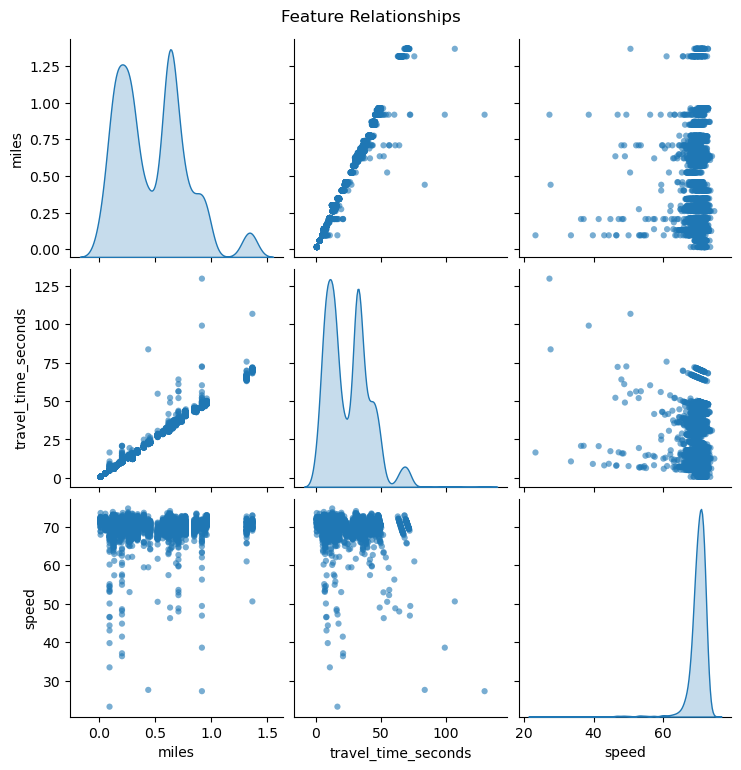

In [354]:
# use sns.pairplot to visualize the relationship between features and labels in X_full
# label
label_col = ['travel_time_seconds','speed']
feature_cols = ['miles']

sample_df = df_baseline.sample(n=min(len(df_baseline), 3000), random_state=42)  # adjust sample size
sns.pairplot(
    sample_df,
    vars=feature_cols+label_col,
    # hue='any_event',
    diag_kind='kde',
    # palette='Set2',
    plot_kws={'alpha': 0.6, 's': 20, 'edgecolor': 'none'}
)

plt.suptitle("Feature Relationships", y=1.02)
plt.show()

In [345]:
average = pd.DataFrame({'tmc': [], 'time': [], 'average_speed': [], 'n': []})
tmc_list = df_baseline.tmc.unique()

for tmc in tmc_list:
    df_tmc_filtered = df_baseline.loc[df_baseline['tmc'] == tmc]
    time_list = df_tmc_filtered['time'].unique()
    for timeReport in time_list:
        df_time_filtered = df_tmc_filtered.loc[df_tmc_filtered['time'] == timeReport]
        day_list = df_time_filtered['day_of_week'].unique()
        average_speed = df_time_filtered['speed'].mean(axis=0)
        average.loc[-1] = [tmc, timeReport, average_speed, len(df_time_filtered)]
        average.index += 1
    

In [346]:
average

,tmc,time,average_speed,n
1199,115+04177,00:00:00,69.131667,100
1198,115+04177,01:00:00,68.444371,100
1197,115+04177,02:00:00,69.838333,100
1196,115+04177,03:00:00,70.995833,100
1195,115+04177,04:00:00,71.574833,100
...,...,...,...,...
4,115P05165,19:00:00,70.947811,99
3,115P05165,20:00:00,70.537710,99
2,115P05165,21:00:00,70.874304,99
1,115P05165,22:00:00,70.277609,99


In [347]:
df_balanced = df_balanced.reset_index(names=['tmc', 'datetime'])

In [348]:
df_balanced['time'] = df_balanced['datetime'].dt.time
df_balanced['date'] = df_balanced['datetime'].dt.date
df_balanced['day_of_week'] = df_balanced['datetime'].dt.day_of_week

In [349]:
def compute_ratio(r):
    m = (average['tmc'].eq(r['tmc'])
         & average['time'].eq(r['time'])
        )
    vals = average.loc[m, 'average_speed']
    if len(vals) == 1:
        return r['speed'] / vals.iloc[0]
    elif len(vals) == 0:
        return np.nan   
    else:
        return r['speed'] / vals.iloc[0]

df_balanced['ratio'] = df_balanced.apply(compute_ratio, axis=1)
df_balanced['event_happened'] = df_balanced.apply(lambda x: x[events_col].sum(), axis=1)

In [362]:
df_balanced.shape
events_col

['evt_cat_major',
 'evt_cat_minor',
 'evt_cat_closure',
 'evt_cat_obstruction',
 'evt_cat_misc']

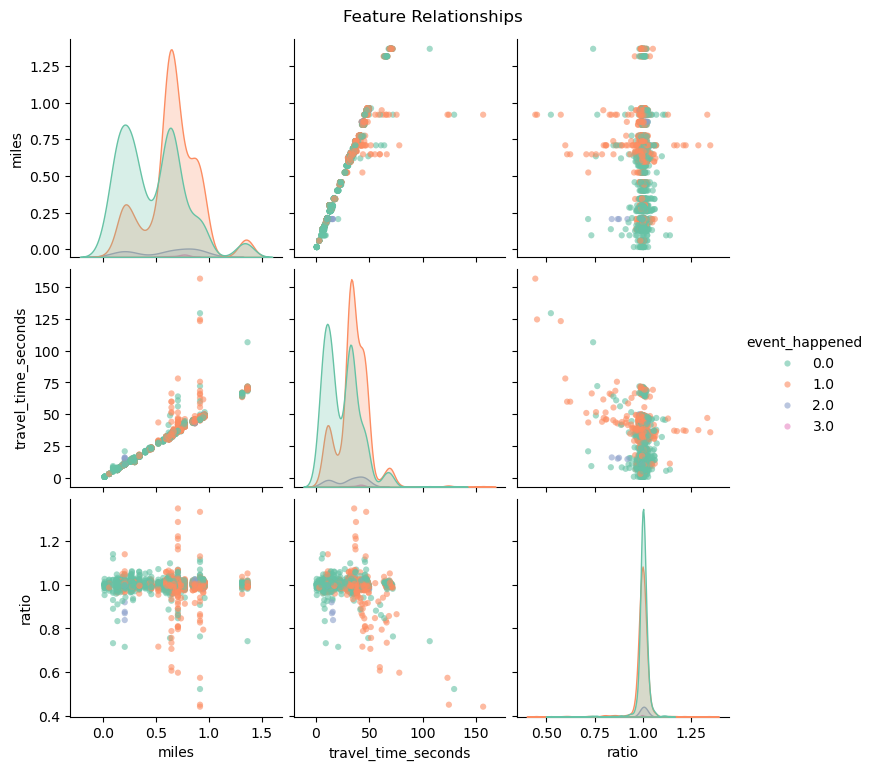

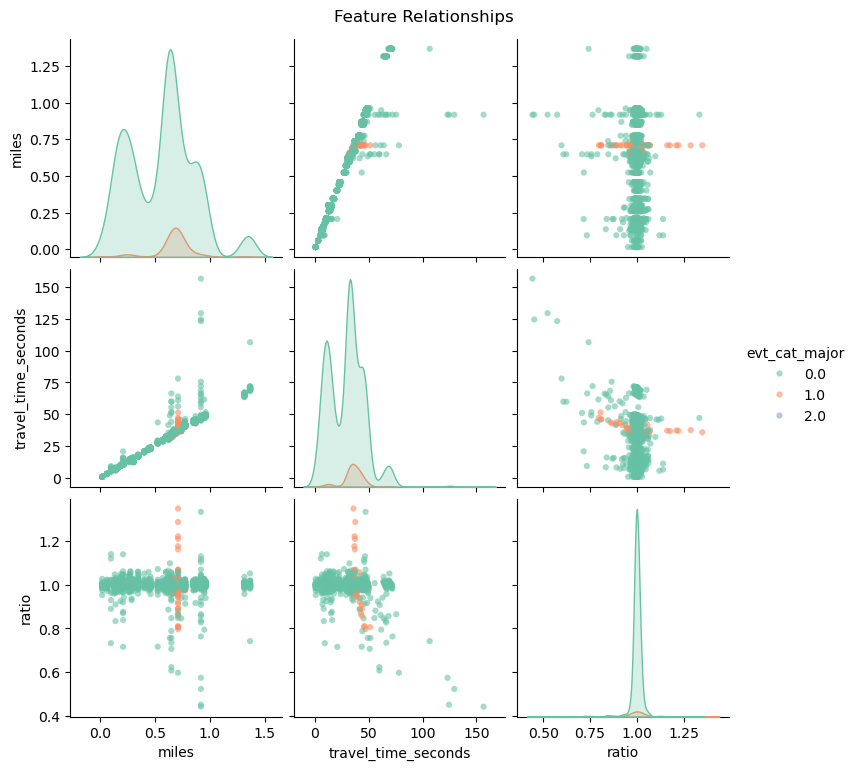

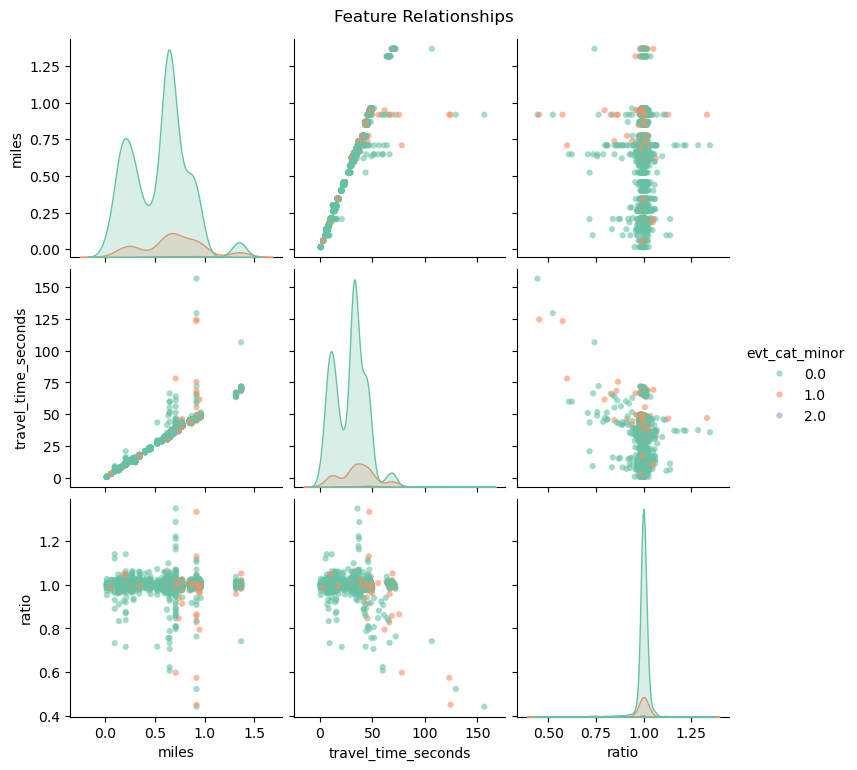

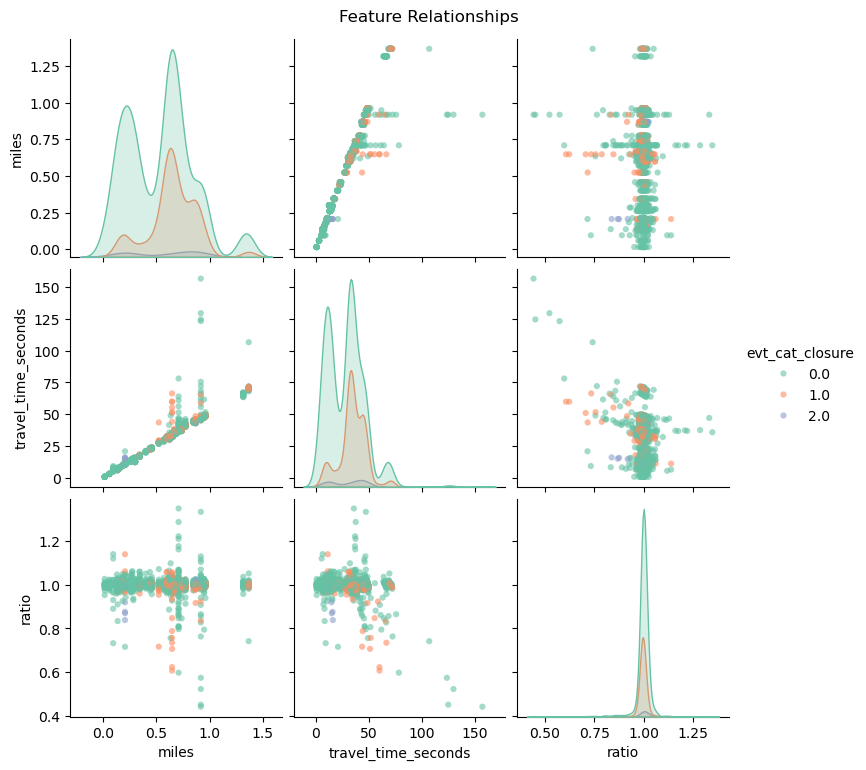

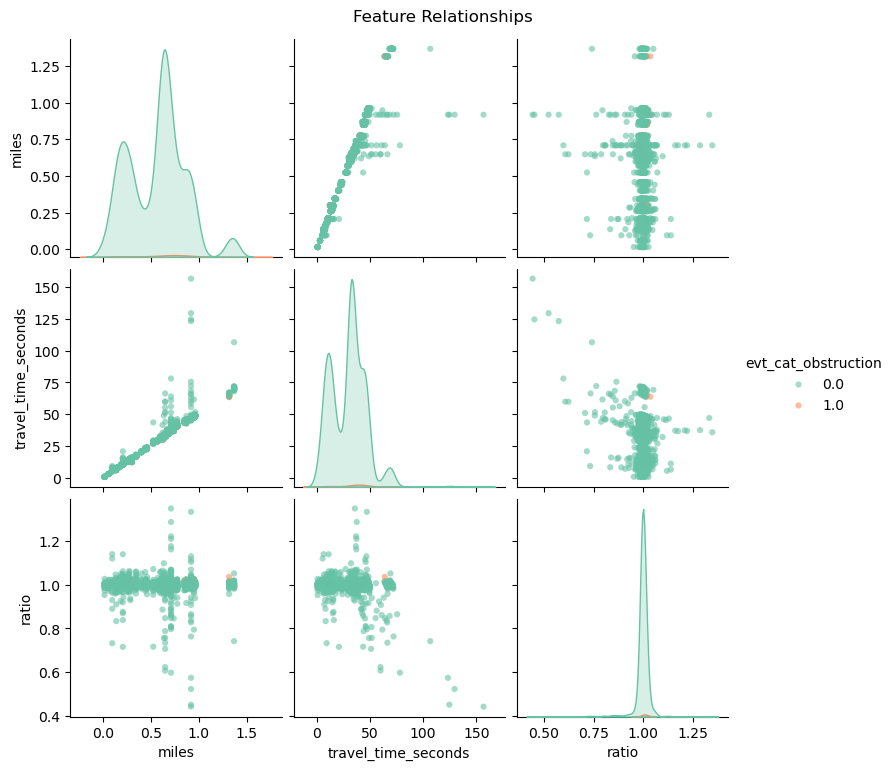

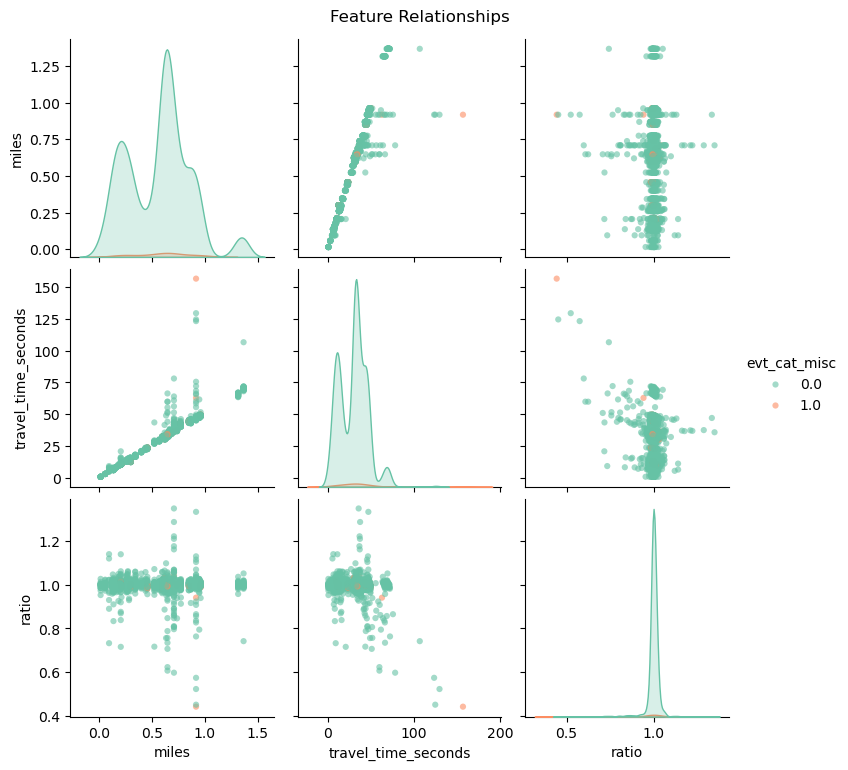

In [369]:
# use sns.pairplot to visualize the relationship between features and labels in X_full
# label
label_col = ['travel_time_seconds','ratio']
feature_cols = [ 'miles']

sample_df = df_balanced.sample(n=min(len(df_balanced), 3000), random_state=42)  # adjust sample size
for col in ['event_happened'] + events_col:
    sns.pairplot(
        sample_df,
        vars=feature_cols+label_col,
        hue=col,
        diag_kind='kde',
        palette='Set2',
        plot_kws={'alpha': 0.6, 's': 20, 'edgecolor': 'none'}
    )

    plt.suptitle("Feature Relationships", y=1.02)
    plt.show()

In [352]:
df_baseline['ratio'] = df_baseline.apply(compute_ratio, axis=1)

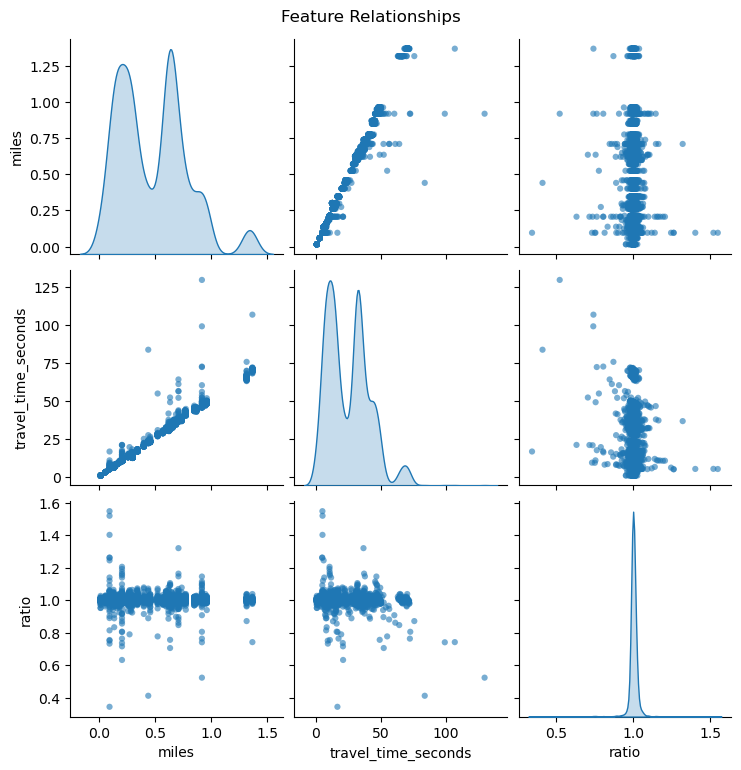

In [357]:
# use sns.pairplot to visualize the relationship between features and labels in X_full
# label
label_col = ['travel_time_seconds','ratio']
feature_cols = ['miles']

sample_df = df_baseline.sample(n=min(len(df_baseline), 3000), random_state=42)  # adjust sample size
sns.pairplot(
    sample_df,
    vars=feature_cols+label_col,
    # hue='event_happened',
    diag_kind='kde',
    # palette='Set2',
    plot_kws={'alpha': 0.6, 's': 20, 'edgecolor': 'none'}
)

plt.suptitle("Feature Relationships", y=1.02)
plt.show()